# PACKAGES

In [24]:
# Data Management
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import cftime

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
from cartopy import config
import cartopy.crs as ccrs

# Statistics
import climlab
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import scipy.stats as st

# Window Display
import warnings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings('ignore')
%matplotlib inline

# ENSO - Introduction

The El Nino Southern Oscillation is a coupled ocean-atmosphere phenomenon that has big implications for climate variability.

It is the largest signal of interannual climate variability, and is phase-locked to the seasons - this means it peaks in winter (DJF).

ENSO refers to anomalous SST patterns (positive anomalies = El Nino, negative anomalies = La Nina) and the associated oscillation in sea-level pressures (SLP). You can identify these patterns by using linear regression onto an ENSO index (typically nino3.4) or compositing.

Let's look at these patterns using both methods.

#### Data

In [2]:
## Load SST and SLP data
SST = xr.open_dataset('/data/keeling/a/tjhanke2/enso-energy-budget/Data/raw_data/ERA5_data/ERA5_mon_1979-2019_sea_surface_temperature.nc').sst
SLP = xr.open_dataset('/data/keeling/a/cristi/a/data/ERA5/ERA5_mon_1979-2019_SLP.nc').msl

## Get anomalous SST and SLP
%run /data/keeling/a/tjhanke2/enso-energy-budget/Data/get_data_variables_fncs.ipynb
SST_anom = get_anomaly(SST,0)
SLP_anom = get_anomaly(SLP,0)

In [3]:
## Get nino3.4 region anomalies
nino34 = SST_anom.sel(latitude=slice(5,-5),longitude=slice(190,240))
weight = np.cos(np.deg2rad(SST.latitude))
nino34_mean = nino34.weighted(weight).mean(dim=('longitude','latitude'))
nino34_rolling = nino34_mean.rolling(time=3,center=True).mean()

## Get the nino3.4 composite indexer
nino34 = xr.full_like(nino34_rolling,'none',dtype='U4')
nino34[nino34_rolling >= 0.5] = 'nino'
nino34[nino34_rolling <= -0.5] = 'nina'

#### Linear Regression

In [18]:
def regression(x,y):
    ## First, stack data
    y_stack = y.stack(allpoints=('latitude','longitude'))
    
    ## Align to remove nans in X
    i = np.isfinite(x)
    a, b_stack = xr.align(x[i], y_stack[i].dropna(dim='allpoints'))
    
    ## Perform regression
    reg = LinearRegression().fit(a.values.reshape(-1,1),b_stack)
    
    ## Repackage into xarray dataarray
    reg_da = xr.DataArray(data=reg.coef_,
                          coords={'dim_0':b_stack.allpoints.values})

    reg_rename = reg_da.rename({'dim_0':'allpoints'})
    reg_xr = reg_rename.reindex_like(b_stack)
    reg_unstack = reg_xr.unstack('allpoints')

    return reg_unstack[0]

In [21]:
nino34_SST = regression(nino34_rolling,SST_anom)
nino34_SLP = regression(nino34_rolling,SLP_anom)

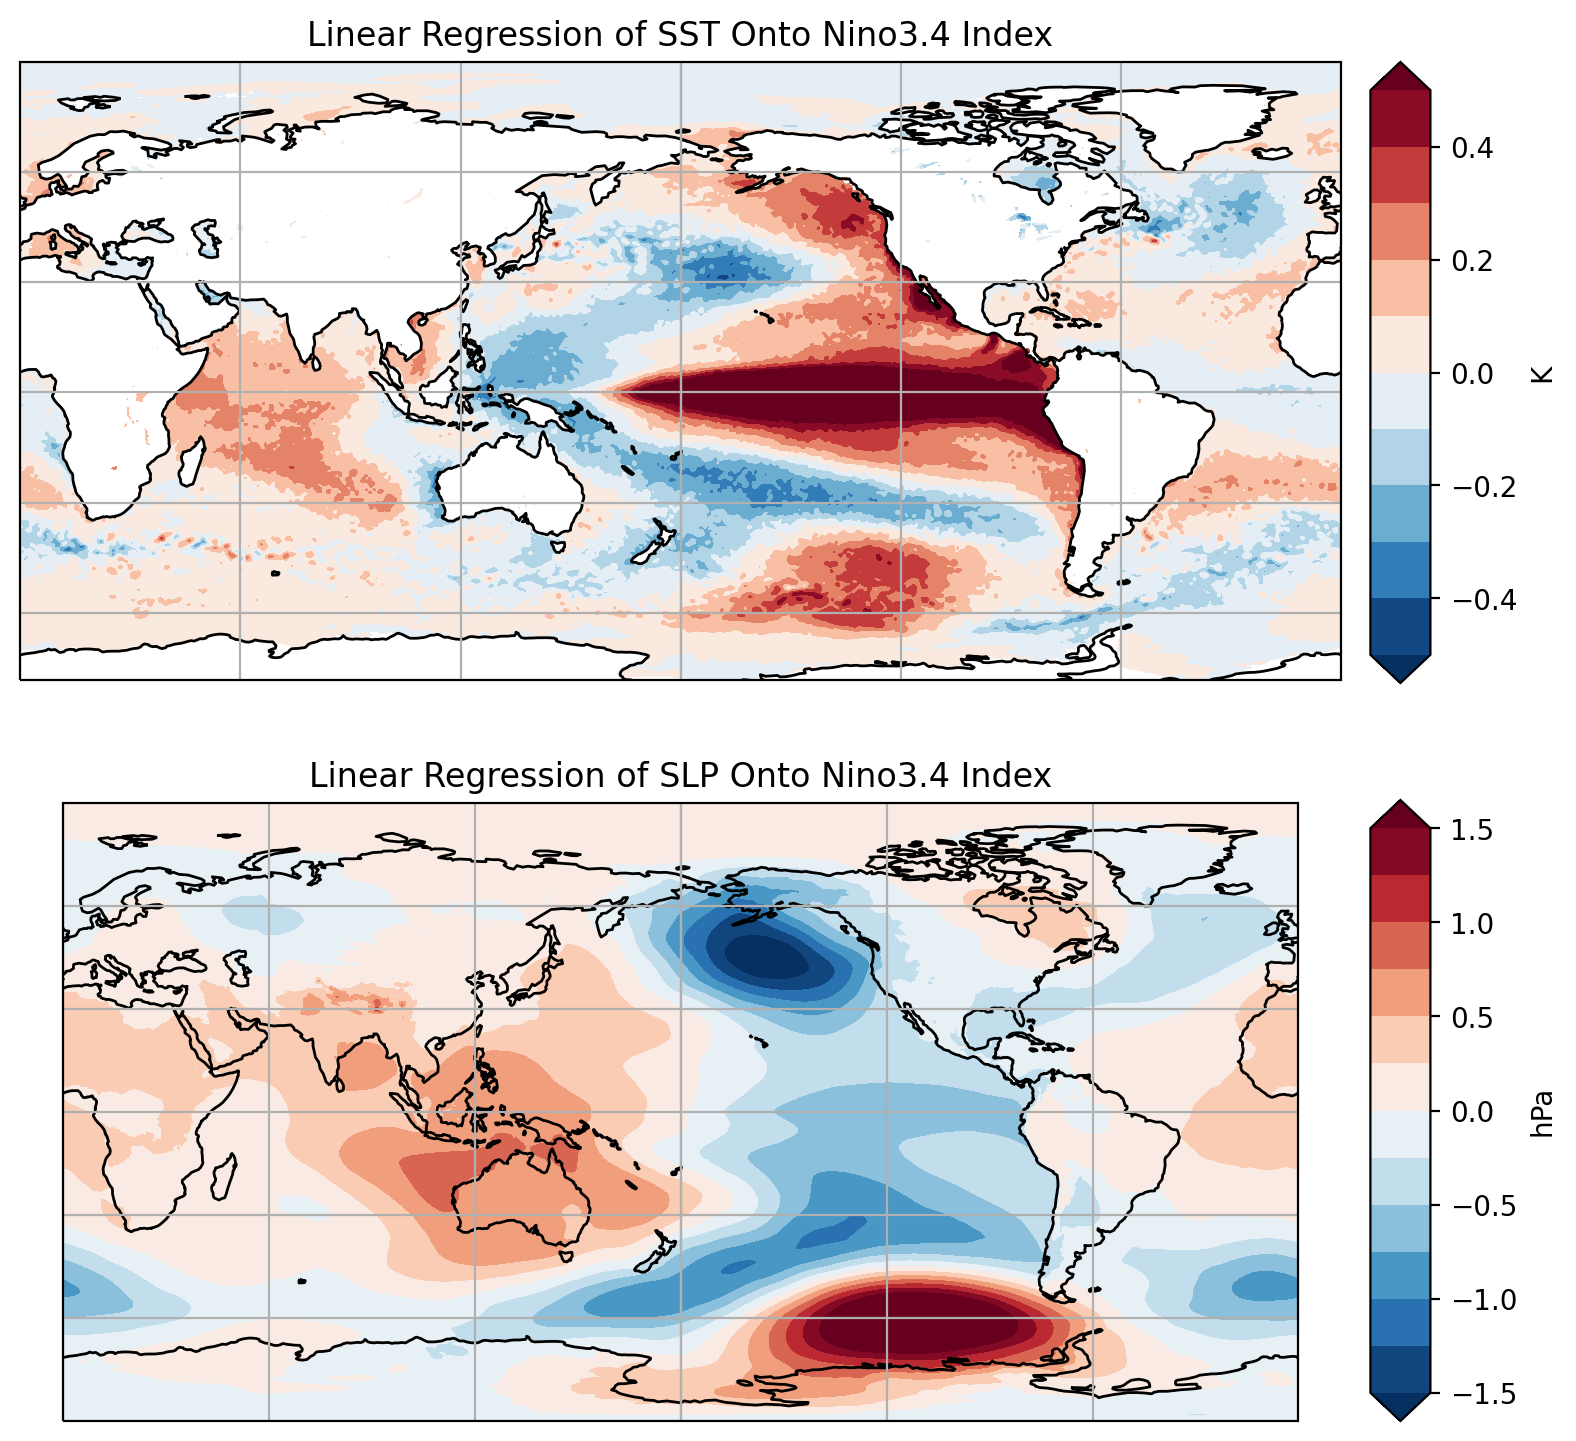

In [24]:
## Make contour plots of nino3.4 SST and SLP
fig, ax = plt.subplots(2, 1, figsize=(12,9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, dpi=200)

cbar1_data = ax[0].contourf(nino34_SST.longitude,nino34_SST.latitude,nino34_SST,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),
               add_colorbar=False,extend='both',levels=np.arange(-0.5,0.6,0.1))
cbar1_ax = fig.add_axes([0.80, 0.535, 0.025, 0.345])
cbar1 = fig.colorbar(cbar1_data, cax=cbar1_ax, orientation='vertical')
cbar1.set_label(label='K', size=10)
ax[0].set_title('Linear Regression of SST Onto Nino3.4 Index');

cbar2_data = ax[1].contourf(nino34_SLP.longitude,nino34_SLP.latitude,nino34_SLP/100,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),
               add_colorbar=False,extend='both',levels=np.arange(-1.5,1.6,0.25))
cbar2_ax = fig.add_axes([0.80, 0.125, 0.025, 0.345])
cbar2 = fig.colorbar(cbar2_data, cax=cbar2_ax, orientation='vertical')
cbar2.set_label(label='hPa', size=10)
ax[1].set_title('Linear Regression of SLP Onto Nino3.4 Index');

for i in range(2):
    ax[i].gridlines()
    ax[i].coastlines()

#### Composites 

In [26]:
def composite(x):
    return x.groupby(nino34.rename('nino34')).mean(dim='time')

In [27]:
SST_comp = composite(SST_anom)
SLP_comp = composite(SLP_anom)

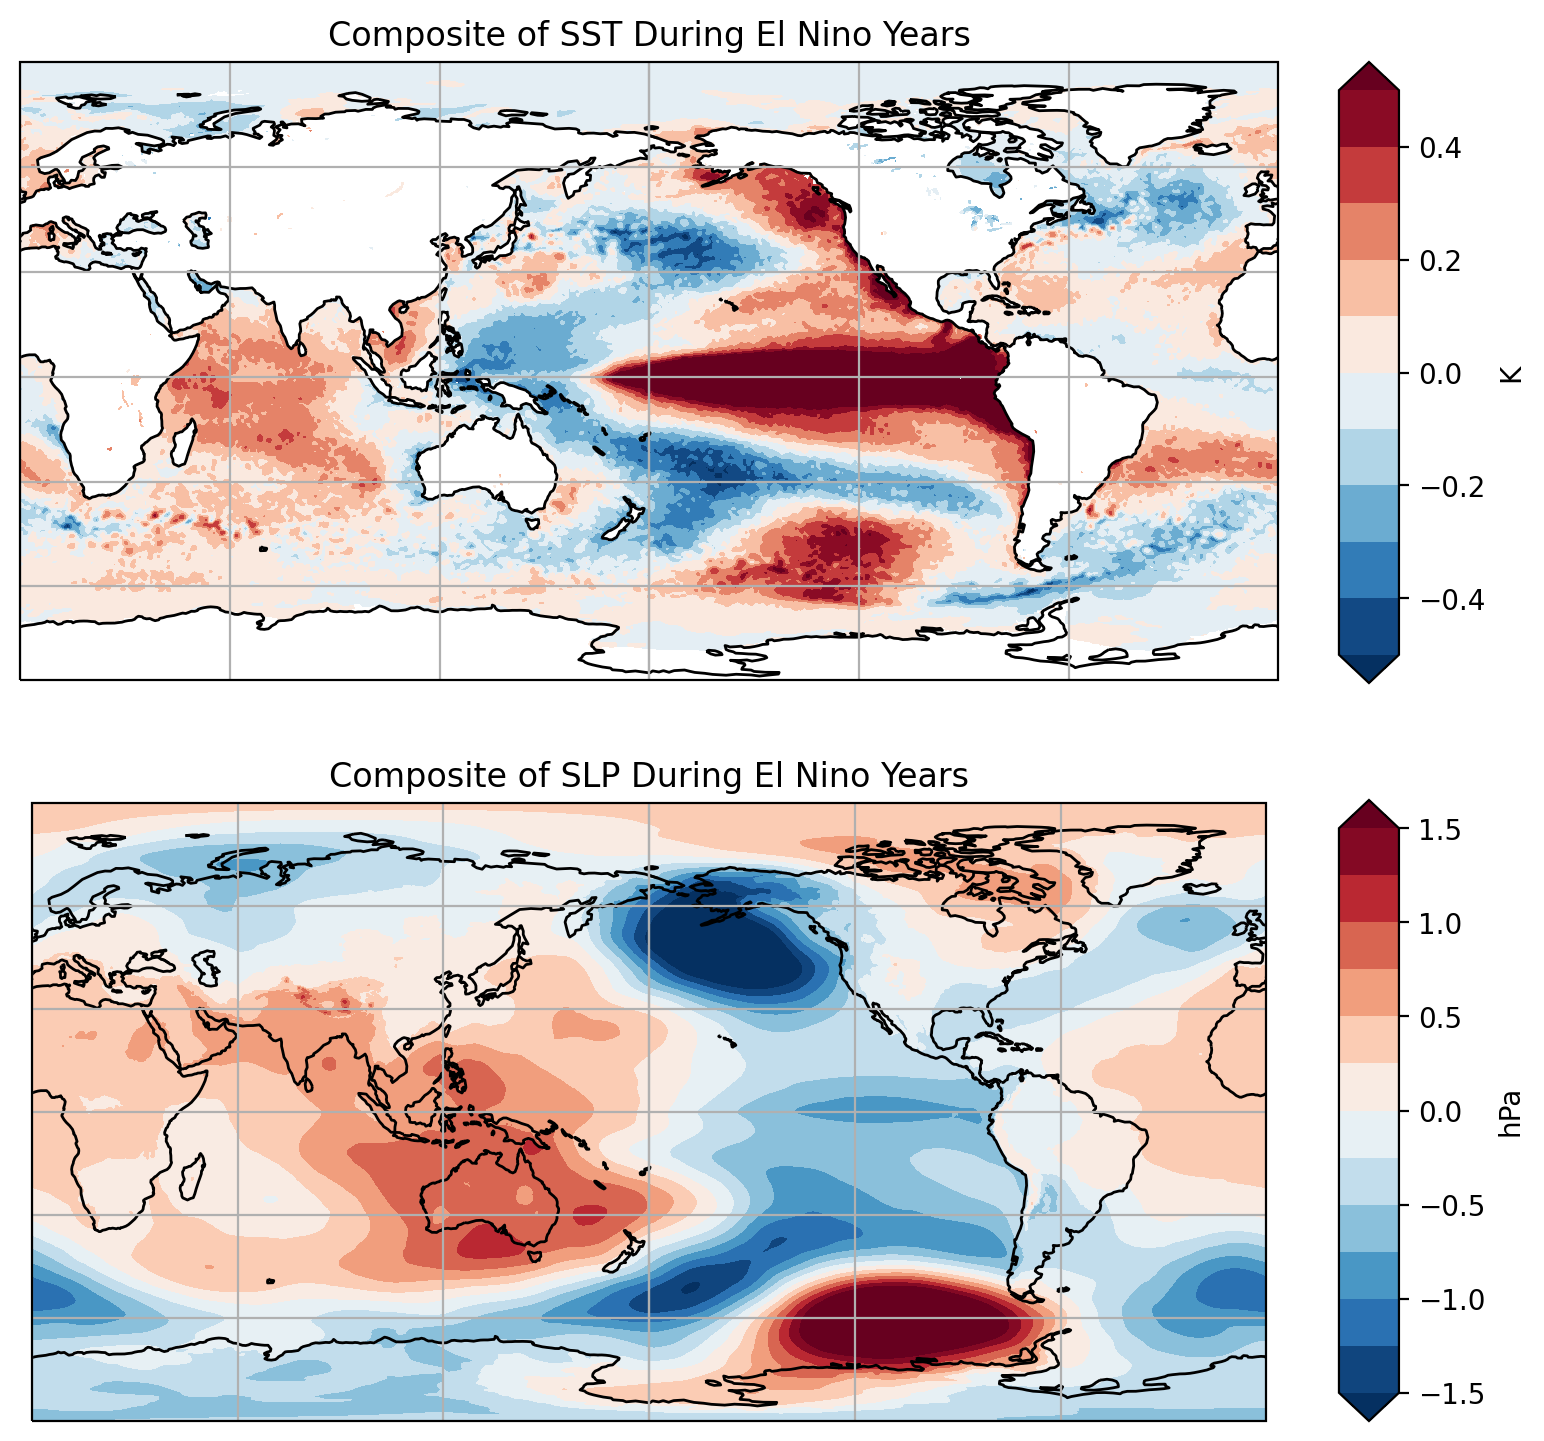

In [29]:
## Make contour plots of nino3.4 SST and SLP
fig, ax = plt.subplots(2, 1, figsize=(12,9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, dpi=200)

cbar1_data = ax[0].contourf(SST_comp.longitude,SST_comp.latitude,SST_comp.sel(nino34='nino'),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),
               add_colorbar=False,extend='both',levels=np.arange(-0.5,0.6,0.1))
cbar1_ax = fig.add_axes([0.80, 0.535, 0.025, 0.345])
cbar1 = fig.colorbar(cbar1_data, cax=cbar1_ax, orientation='vertical')
cbar1.set_label(label='K', size=10)
ax[0].set_title('Composite of SST During El Nino Years');

cbar2_data = ax[1].contourf(SLP_comp.longitude,SLP_comp.latitude,SLP_comp.sel(nino34='nino')/100,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),
               add_colorbar=False,extend='both',levels=np.arange(-1.5,1.6,0.25))
cbar2_ax = fig.add_axes([0.80, 0.125, 0.025, 0.345])
cbar2 = fig.colorbar(cbar2_data, cax=cbar2_ax, orientation='vertical')
cbar2.set_label(label='hPa', size=10)
ax[1].set_title('Composite of SLP During El Nino Years');

for i in range(2):
    ax[i].gridlines()
    ax[i].coastlines()

However, this is just one index that is used to identify ENSO. We can also use other indices depending on the nature of the research we are doing. For instance, the nino3.4 index is great for identifying ENSO-induced SST anomalies, but we could identify an index of ENSO-induced SLP (the Equatorial Southern Oscillation Index), or include the diversity of ENSO events by using the ENSO Longitude index.

Let's see the different indices and compare their SST patterns to the nino3.4 index.

#### Equatorial Southern Oscillation Index 

In [31]:
## The ESOI is SLP_EP - SLP_INDO
weights = np.cos(np.deg2rad(SLP_anom.latitude))
SLP_EP = SLP_anom.sel(latitude=slice(5,-5),longitude=slice(230,300)).weighted(weights).mean(dim=('longitude','latitude')) / 100
SLP_INDO = SLP_anom.sel(latitude=slice(5,-5),longitude=slice(90,130)).weighted(weights).mean(dim=('longitude','latitude')) / 100

ESOI = (SLP_EP - SLP_INDO).rolling(time=3,center=True).mean()
ESOI_nino34_corr = st.pearsonr(ESOI[1:len(ESOI)-1],nino34_rolling.dropna(dim='time'))

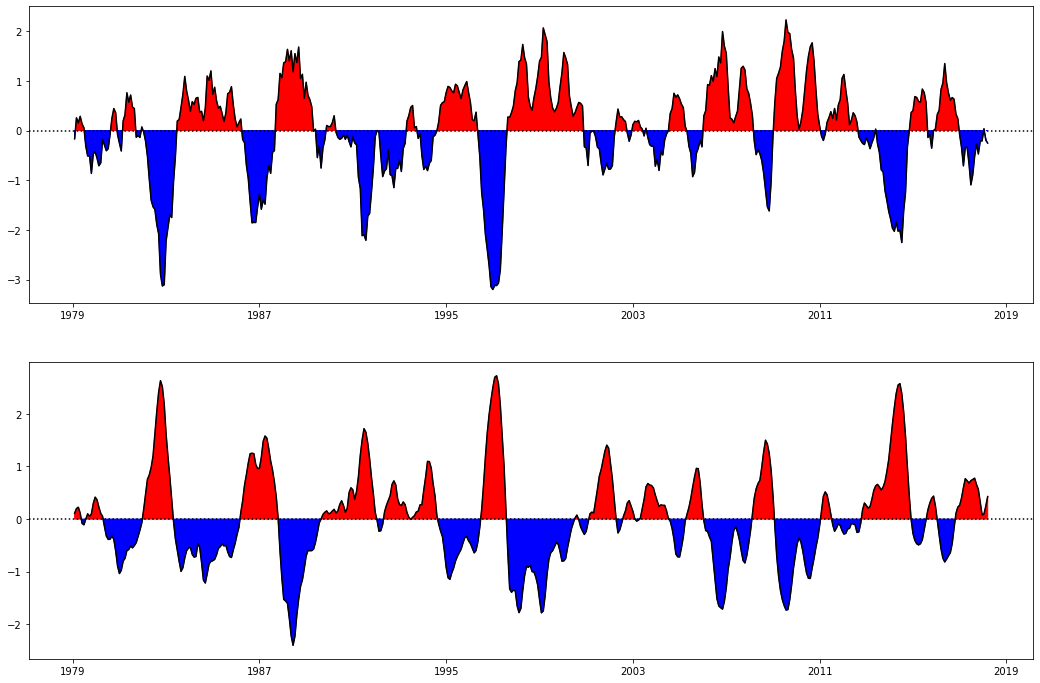

In [23]:
fig, ax = plt.subplots(2,1,figsize=(18,12))

ax[0].fill_between(np.arange(0,len(ESOI)),ESOI,where=ESOI>0,color='r',interpolate=True)
ax[0].fill_between(np.arange(0,len(ESOI)),ESOI,where=ESOI<0,color='b',interpolate=True)
ax[0].plot(ESOI,color='k')

ax[1].fill_between(np.arange(0,len(nino34_rolling)),nino34_rolling,where=nino34_rolling>0,color='r',interpolate=True)
ax[1].fill_between(np.arange(0,len(nino34_rolling)),nino34_rolling,where=nino34_rolling<0,color='b',interpolate=True)
ax[1].plot(nino34_rolling,color='k')

for i in range(0,2):
    ax[i].axhline(y=0,linestyle='dotted',color='k')
    ax[i].set_xticks([0,100,200,300,400,500])
    ax[i].set_xticklabels(['1979','1987','1995','2003','2011','2019']);

In [35]:
print('The correlation between the ESOI and the Nino3.4 index is: ' + str(ESOI_nino34_corr[0]))

The correlation between the ESOI and the Nino3.4 index is: -0.9070333477105731


#### ENSO Longitude Index 

In [54]:
## Get tropical avg SST, and keep any values at each grid point above tropical avg SST values
SST_trop_avg = SST.sel(latitude=slice(5,-5)).weighted(weight).mean(dim=('longitude','latitude'))

SST_lon_mask = xr.where(SST >= SST_trop_avg, 1, 0)

## Get coords of pacific basin
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin = basin.rename({'X': 'longitude', 'Y': 'latitude'})
basin_surf = basin.basin[0]
basin_surf_interp = basin_surf.interp_like(SST, method='nearest')

## Apply basin coords to SST data
SST_lon_mask_basin = SST_lon_mask.where(basin_surf_interp == 2)

## Get ELI
ELI = SST_lon_mask_basin.sel(latitude=slice(5,-5)).weighted(weight).mean(dim=('latitude','longitude'))

In [68]:
## Regress SST onto ELI
ELI_SST = regression(ELI,SST_anom)

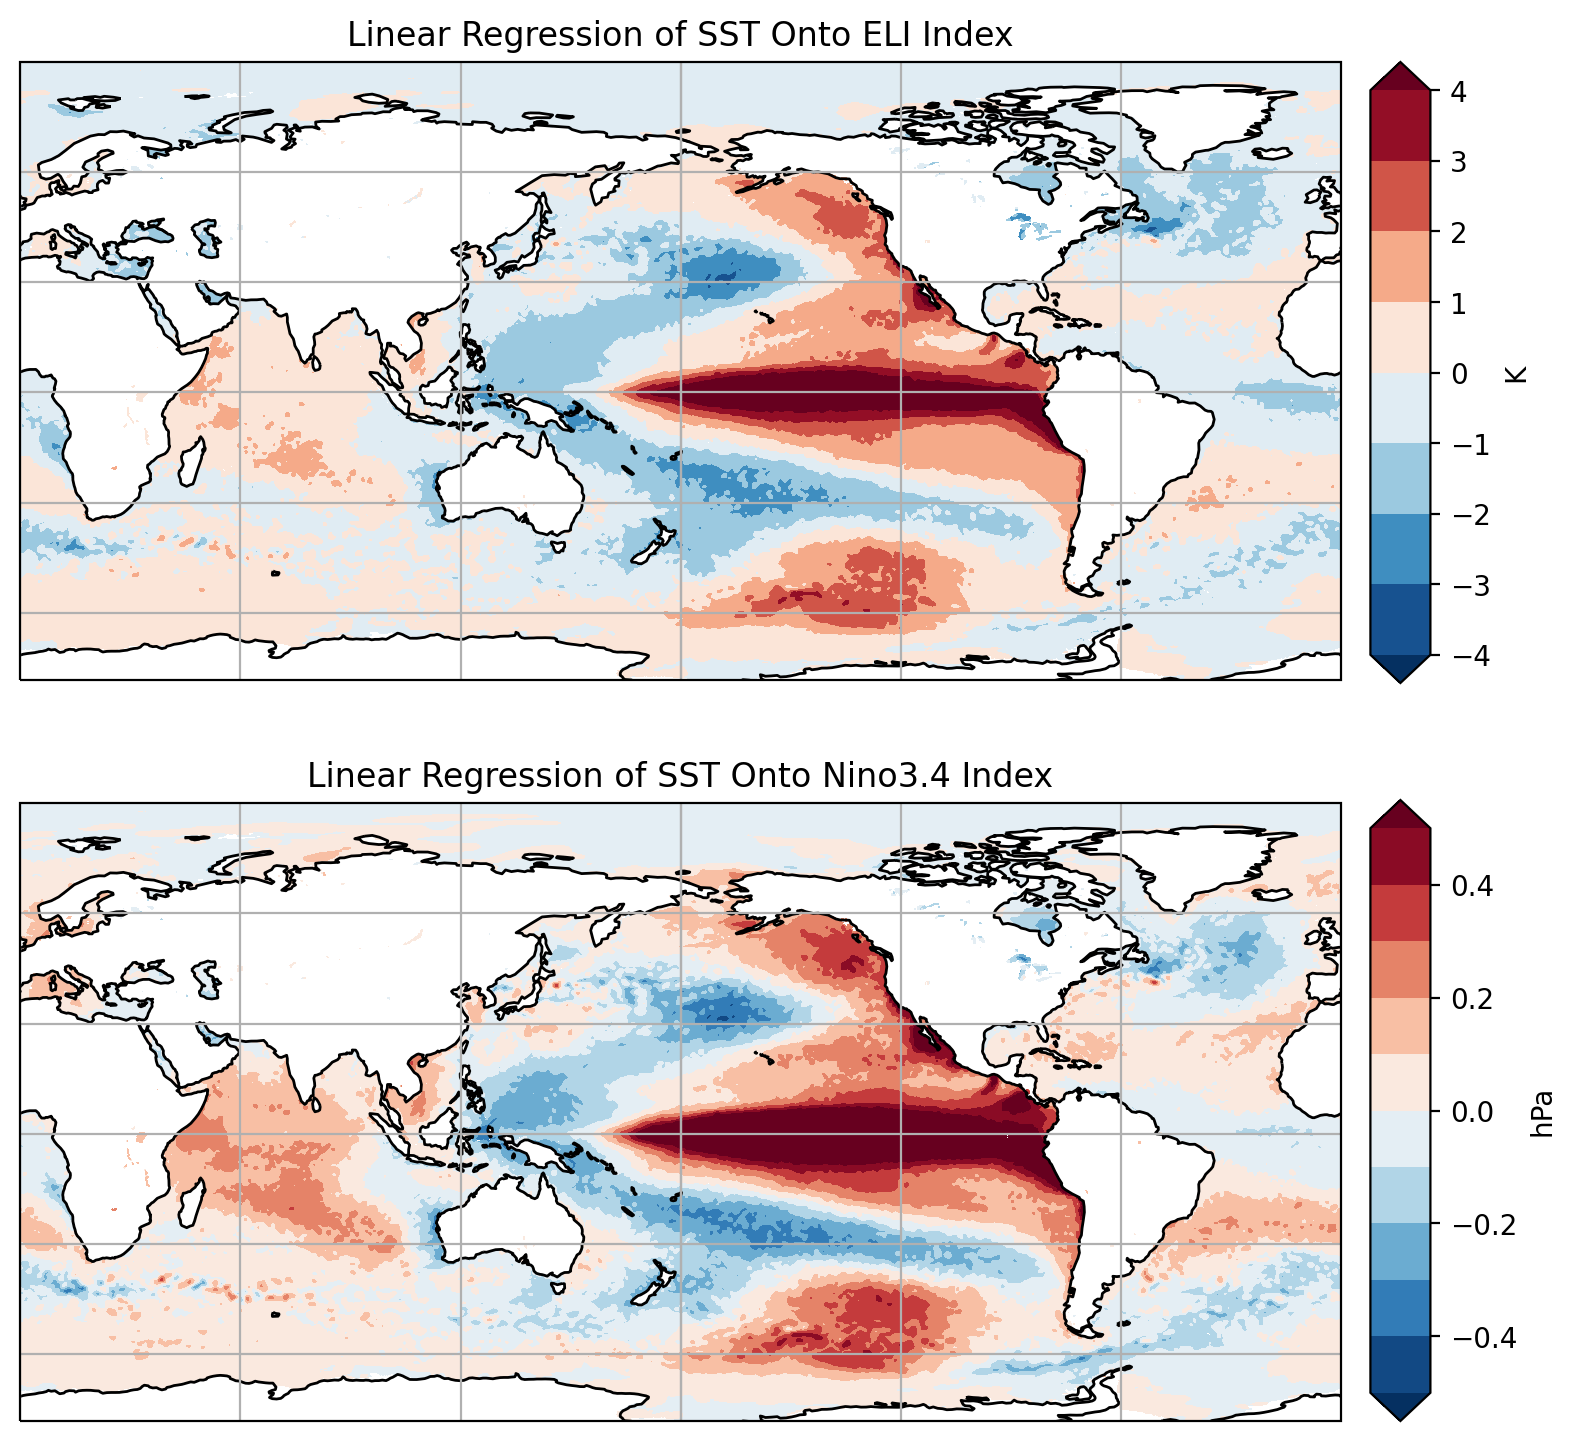

In [74]:
## Make contour plots of nino3.4 SST and SLP
fig, ax = plt.subplots(2, 1, figsize=(12,9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, dpi=200)

cbar1_data = ax[0].contourf(ELI_SST.longitude,ELI_SST.latitude,ELI_SST,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),
               add_colorbar=False,extend='both',levels=np.arange(-4,5,1))
cbar1_ax = fig.add_axes([0.80, 0.535, 0.025, 0.345])
cbar1 = fig.colorbar(cbar1_data, cax=cbar1_ax, orientation='vertical')
cbar1.set_label(label='K', size=10)
ax[0].set_title('Linear Regression of SST Onto ELI Index');

cbar2_data = ax[1].contourf(nino34_SST.longitude,nino34_SST.latitude,nino34_SST,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('RdBu_r'),
               add_colorbar=False,extend='both',levels=np.arange(-0.5,0.6,0.1))
cbar2_ax = fig.add_axes([0.80, 0.125, 0.025, 0.345])
cbar2 = fig.colorbar(cbar2_data, cax=cbar2_ax, orientation='vertical')
cbar2.set_label(label='K', size=10)
ax[1].set_title('Linear Regression of SST Onto Nino3.4 Index');

for i in range(2):
    ax[i].gridlines()
    ax[i].coastlines()